In [8]:
from sophy_util import chat, get_char_prompt, get_chat_prompt
from graph_util import display_graph

from langchain_groq import ChatGroq
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langgraph.graph import StateGraph, Graph, START, END
from langgraph.graph import StateGraph
from langgraph.graph.message import AnyMessage, add_messages
from langgraph.checkpoint.memory import MemorySaver
from typing_extensions import TypedDict

from pydantic import BaseModel, Field

In [9]:
ss_agent_key = "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"
llm = ChatGroq(
    model="llama-3.3-70b-versatile",
    api_key=ss_agent_key
)


class SophyState(TypedDict):
    exchange: int
    conv_sum: str
    conversation_history: list[AnyMessage]
    latest_exchanges: list[AnyMessage]
    user_input: str
    agent_response: str

class AgentResponse(BaseModel):
    "Route to proceed in"
    pickedRoute: str = Field(description= "The route to proceed in, can only be: 'continue_chat', 'crisis_hepline', 'resource_suggestion', 'end_chat' ")
    reason: str = Field(description ="Reason for picking the route")

llm_agent_response = llm.with_structured_output(AgentResponse)

def sophy_chat(chat_state:SophyState):
    exchange = chat_state.get("exchange",0)
    conv_sum = chat_state.get("conv_sum","")
    conversation_history = chat_state.get("conversation_history",[])
    latest_exchanges = chat_state.get("latest_exchanges",[])
    user_input = chat_state["user_input"]
    exchange,conv_sum,conversation_history,latest_exchanges,user_input = chat(llm,exchange,conv_sum,conversation_history,latest_exchanges,user_input, exc_window=5)

    return {
        "exchange":exchange,
        "conv_sum":conv_sum,
        "conversation_history":conversation_history,
        "latest_exchanges":latest_exchanges,
        "user_input":user_input
    }








In [10]:

def agent(chat_state:SophyState):

    conversation_history = chat_state.get("conversation_history",[])
    user_input = chat_state["user_input"]

    if len(conversation_history < 2):
        select_conv = conversation_history
    else:
        select_conv = conversation_history[-2:]
    
    prompt = f'''
        You are an autonoums agent in a mental health support chat system.

        Based on the current human input and previous exchanges in the conversation pick the best route for the conversation to proceed in.
        
        Previous Exchanges:
        {select_conv}
        
        Current Human Input:
        {user_input}

        Routes:
        continue_chat : Normal chat route with mental health assistant
        crisis_hepline : Speaclized route connects user to 24X7 crisis helpline to professionals will help the human avoid crisis like suicide and other harms.
        resource_suggestion : Specialized provider of resources suggestions for coping techniques, therpaists contacts
        end_chat : Specialized end message if the user intends to end the chat

        If you can not provide answers for sucidial tendencies or harmful pick the crisis helpine route so that user can recieve help from professionals.

        If undecided and there are no harmful intentions always pick continue_chat

        '''
    
    agent_response  = llm_agent_response.invoke(prompt)
    
    return {"agent_response":agent_response}


In [19]:
from typing import Union, Literal, Sequence

def agent_edges(chat_state:SophyState) -> Union[Literal["Sophy", "crisisHandler", "resourceRAG"],END]:
    agent_reponse = chat_state.get("agent_response")
    picked_route = agent_reponse["pickedRoute"]

    if picked_route == 'continue_chat':
        return "Sophy"
    elif picked_route == 'crisis_helpline':
        return "crisisHandler"
    elif picked_route =='resource_suggestion':
        return "resourceRAG"
    elif picked_route =='end_chat':
        return END
    else:
        return "Sophy"



In [17]:
def resources_rag():
    return "Here are some resources: link to meditation techniques, link to coping techniques"

def crisis_handler():
    return "You seem to be in an active crisis please call 100"

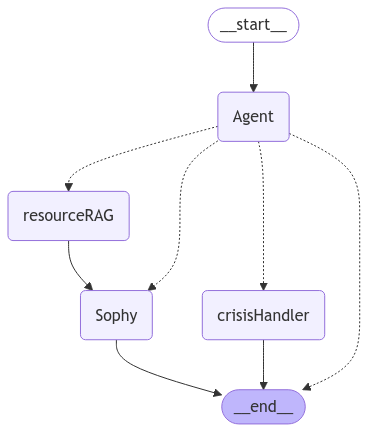

In [20]:
builder = StateGraph(SophyState)
builder.add_node("Agent",agent)
builder.add_node("Sophy",sophy_chat)
builder.add_node("resourceRAG",resources_rag)
builder.add_node("crisisHandler",crisis_handler)

builder.add_edge(START, "Agent")
builder.add_conditional_edges("Agent", agent_edges)
builder.add_edge("Sophy",END)
builder.add_edge("resourceRAG","Sophy")
builder.add_edge("crisisHandler",END)



memory = MemorySaver()
sophy_state_graph = builder.compile(
    checkpointer=memory,
)

display_graph(sophy_state_graph)